In [1]:
import sys, os, argparse
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf        
sys.path.append('../')

from data_read import *
from net import *

# ────────────────────────────── CLI ──────────────────────────────
parser = argparse.ArgumentParser()

parser.add_argument('--dataset_name',          dest='dataset_name',
                    default='MSCOCO',
                    help='MSCOCO, GoogleMap, GoogleEarth, DayNight')

parser.add_argument('--epoch_load_one',        dest='epoch_load_one',
                    type=int, default=3)
parser.add_argument('--epoch_load_two',        dest='epoch_load_two',
                    type=int, default=3)
parser.add_argument('--epoch_load_three',      dest='epoch_load_three',
                    type=int, default=3)

parser.add_argument('--num_iters',             dest='num_iters',
                    type=int, default=50)

parser.add_argument('--feature_map_type',      dest='feature_map_type',
                    default='special',          # <‑‑ only “special”
                    help='special')

parser.add_argument('--initial_type',          dest='initial_type',
                    default='multi_net',        # <‑‑ only “multi_net”
                    help='multi_net')

parser.add_argument('--load_epoch_multinet',   dest='load_epoch_multinet',
                    default=[50, 50, 40])

input_parameters = parser.parse_args([])

# ─────────────────────── GPU memory limit (optional) ───────────────────────
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        print(e)

# ─────────────────────────── Functions (unchanged) ─────────────────────────
def construct_matrix_regression(batch_size, network_output, network_output_2=[0]):
    extra = tf.ones((batch_size, 1))
    predicted_matrix = tf.concat([network_output, extra], axis=-1)
    predicted_matrix = tf.reshape(predicted_matrix, [batch_size, 3, 3])
    if len(np.shape(network_output_2)) > 1:
        predicted_matrix_2 = tf.concat([network_output_2, extra], axis=-1)
        predicted_matrix_2 = tf.reshape(predicted_matrix_2, [batch_size, 3, 3])
    hh_matrix = []
    for i in range(batch_size):
        if len(np.shape(network_output_2)) > 1:
            hh_matrix.append(np.linalg.inv(np.dot(predicted_matrix_2[i, :, :],
                                                  predicted_matrix[i, :, :])))
        else:
            hh_matrix.append(np.linalg.inv(predicted_matrix[i, :, :]))
    return np.asarray(hh_matrix)

def initial_motion_COCO():
    matrix_list = []
    for _ in range(1):
        src_points  = [[0, 0], [127, 0], [127, 127], [0, 127]]
        tgt_points  = [[32, 32], [160, 32], [160, 160], [32, 160]]
        src_points  = np.reshape(src_points, [4, 1, 2])
        tgt_points  = np.reshape(tgt_points, [4, 1, 2])
        h_matrix, _ = cv2.findHomography(src_points, tgt_points, 0)
        matrix_list.append(h_matrix)
    return np.asarray(matrix_list).astype(np.float32)

def construct_matrix(initial_matrix, scale_factor, batch_size):
    initial_matrix = tf.cast(initial_matrix, dtype=tf.float32)
    scale_matrix = np.eye(3) * scale_factor
    scale_matrix[2, 2] = 1.0
    scale_matrix = tf.cast(scale_matrix, dtype=tf.float32)
    scale_matrix_inverse = tf.linalg.inv(scale_matrix)
    scale_matrix = tf.expand_dims(scale_matrix, axis=0)
    scale_matrix = tf.tile(scale_matrix, [batch_size, 1, 1])
    scale_matrix_inverse = tf.expand_dims(scale_matrix_inverse, axis=0)
    scale_matrix_inverse = tf.tile(scale_matrix_inverse, [batch_size, 1, 1])
    return tf.matmul(tf.matmul(scale_matrix, initial_matrix), scale_matrix_inverse)

def average_cornner_error(batch_size, predicted_matrix, u_list, v_list,
                          top_left_u=0, top_left_v=0,
                          bottom_right_u=127, bottom_right_v=127):
    four_conner = [[top_left_u,      top_left_v,      1],
                   [bottom_right_u,  top_left_v,      1],
                   [bottom_right_u,  bottom_right_v,  1],
                   [top_left_u,      bottom_right_v,  1]]
    four_conner = np.asarray(four_conner).T
    four_conner = np.expand_dims(four_conner, axis=0)
    four_conner = np.tile(four_conner, [batch_size, 1, 1]).astype(np.float32)
    new_pts     = tf.matmul(predicted_matrix, four_conner)
    new_pts    /= new_pts[:, 2:, :]
    u_predict   = new_pts[:, 0, :]
    v_predict   = new_pts[:, 1, :]
    return tf.reduce_mean(tf.sqrt(tf.square(u_predict - u_list) +
                                  tf.square(v_predict - v_list)))

def calculate_feature_map(input_tensor):
    bs, height, width, channel = tf.shape(input_tensor)
    patches = tf.image.extract_patches(input_tensor,
                                       sizes=(1, 3, 3, 1),
                                       strides=(1, 1, 1, 1),
                                       rates=(1, 1, 1, 1),
                                       padding='SAME')
    patches = tf.reshape(patches, (bs, height, width, channel, 9))
    mean    = tf.reduce_mean(patches, axis=3, keepdims=True)
    patches = patches - mean
    patches_T = tf.transpose(patches, (0, 1, 2, 4, 3))
    var_mat   = tf.matmul(patches_T, patches)
    trace     = tf.linalg.trace(var_mat)
    row_sum   = tf.reduce_sum(var_mat, axis=-1)
    max_rs    = tf.reduce_max(row_sum, axis=-1)
    min_rs    = tf.reduce_min(row_sum, axis=-1)
    mimic_ratio = (max_rs + min_rs) / (2.0 * trace)
    return tf.expand_dims(mimic_ratio, axis=-1)

# ──────────────── Feature‑map networks (SPECIAL only) ───────────────
if input_parameters.feature_map_type != 'special':
    raise ValueError("Only 'special' feature_map_type is supported.")

load_path_one   = f'./checkpoints/{input_parameters.dataset_name}/level_one/'
load_path_two   = f'./checkpoints/{input_parameters.dataset_name}/level_two/'
load_path_three = f'./checkpoints/{input_parameters.dataset_name}/level_three/'

level_one_input     = ResNet_first_input()
level_one_template  = ResNet_first_template()
level_two_input     = ResNet_second_input()
level_two_template  = ResNet_second_template()
level_three_input   = ResNet_third_input()
level_three_template= ResNet_third_template()

level_one_input.load_weights(   load_path_one   + f'epoch_{input_parameters.epoch_load_one}input_full')
level_one_template.load_weights(load_path_one   + f'epoch_{input_parameters.epoch_load_one}template_full')
level_two_input.load_weights(   load_path_two   + f'epoch_{input_parameters.epoch_load_two}input_full')
level_two_template.load_weights(load_path_two   + f'epoch_{input_parameters.epoch_load_two}template_full')
level_three_input.load_weights( level_path_three:=load_path_three + f'epoch_{input_parameters.epoch_load_three}input_full')
level_three_template.load_weights(load_path_three + f'epoch_{input_parameters.epoch_load_three}template_full')

# ─────────────── Initialisation network (MULTI‑NET only) ───────────────
if input_parameters.initial_type != 'multi_net':
    raise ValueError("Only 'multi_net' initial_type is supported.")

save_path_one   = f'./checkpoints/{input_parameters.dataset_name}/regression_stage_1/'
save_path_two   = f'./checkpoints/{input_parameters.dataset_name}/regression_stage_2/'
save_path_three = f'./checkpoints/{input_parameters.dataset_name}/regression_stage_3/'

regression_network_one   = Net_first()
regression_network_two   = Net_second()
regression_network_three = Net_third()

regression_network_one.load_weights(  save_path_one   + f'epoch_{input_parameters.load_epoch_multinet[0]}')
regression_network_two.load_weights(  save_path_two   + f'epoch_{input_parameters.load_epoch_multinet[1]}')
regression_network_three.load_weights(save_path_three + f'epoch_{input_parameters.load_epoch_multinet[2]}')

# ──────────────── Lucas‑Kanade layers ────────────────
LK_layer_one   = Lucas_Kanade_layer(batch_size=1, height_template=128, width_template=128, num_channels=1)
LK_layer_two   = Lucas_Kanade_layer(batch_size=1, height_template=64,  width_template=64,  num_channels=1)
LK_layer_three = Lucas_Kanade_layer(batch_size=1, height_template=32,  width_template=32,  num_channels=1)
LK_layer_regression = Lucas_Kanade_layer(batch_size=1, height_template=192, width_template=192, num_channels=3)

# ─────────────────────── Data loaders ───────────────────────
if   input_parameters.dataset_name == 'MSCOCO':
    data_loader_caller = data_loader_MSCOCO('val')
elif input_parameters.dataset_name == 'GoogleMap':
    data_loader_caller = data_loader_GoogleMap('val')
elif input_parameters.dataset_name == 'GoogleEarth':
    data_loader_caller = data_loader_GoogleEarth('val')
elif input_parameters.dataset_name == 'DayNight':
    data_loader_caller = data_loader_DayNight('val')
else:
    raise ValueError('Unknown dataset name')


1 Physical GPUs, 1 Logical GPUs


2025-07-19 23:40:24.292681: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-07-19 23:40:24.292696: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-19 23:40:24.292699: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-07-19 23:40:24.292724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-19 23:40:24.292736: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


6387



=== Pair 1 ===
Homography corner RMSE: 39.463 px


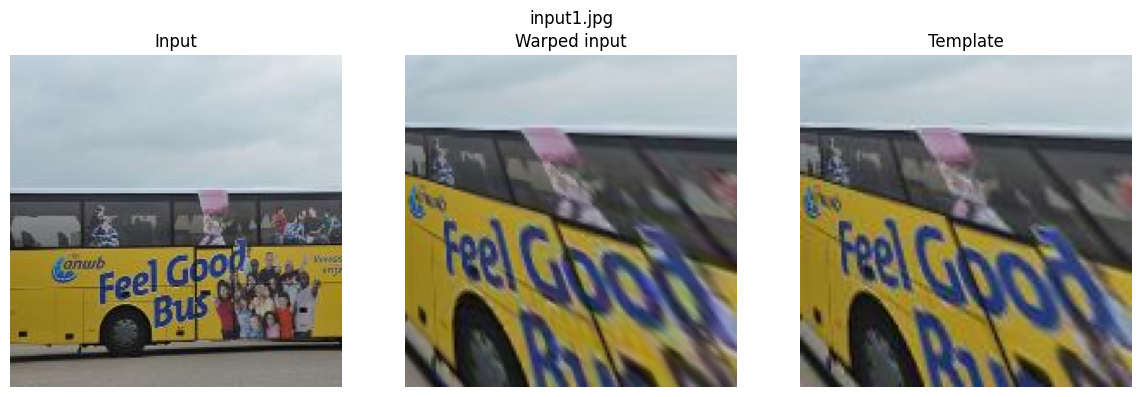


=== Pair 2 ===
Homography corner RMSE: 52.041 px


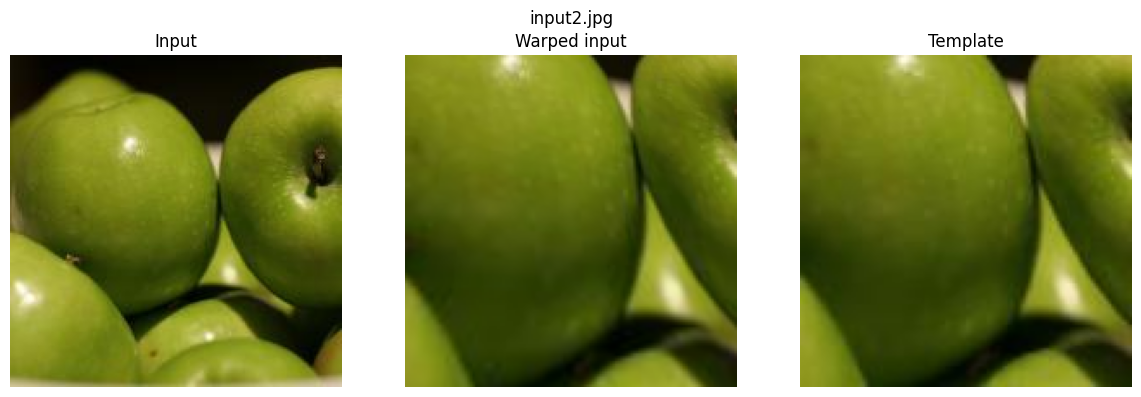


=== Pair 3 ===
Homography corner RMSE: 59.266 px


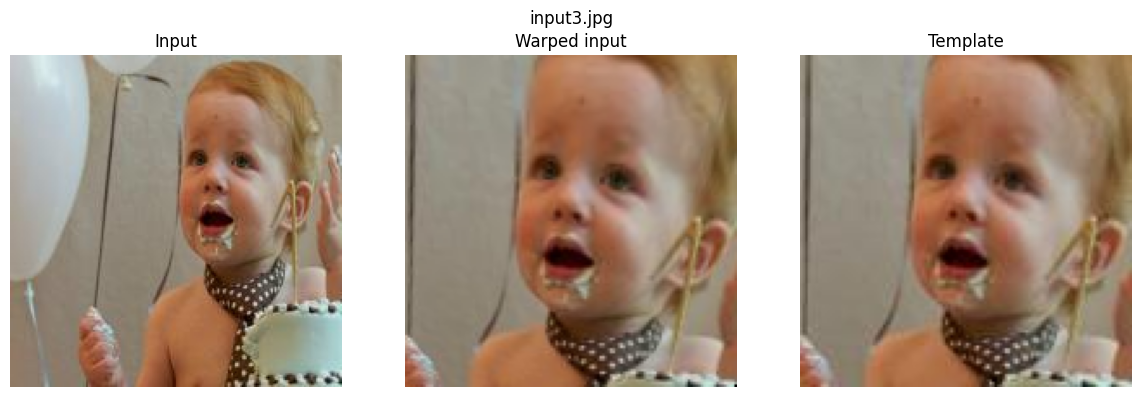


=== Pair 4 ===
Homography corner RMSE: 22.743 px


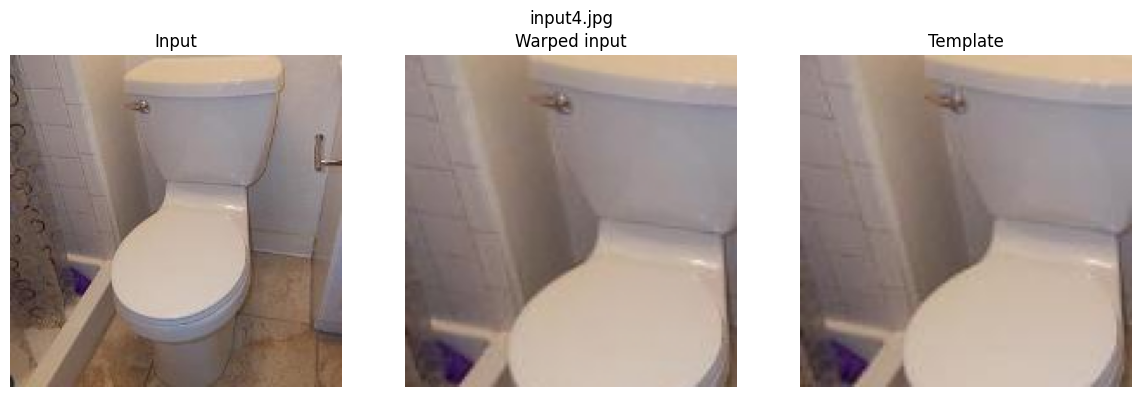


=== Pair 5 ===
Homography corner RMSE: 55.126 px


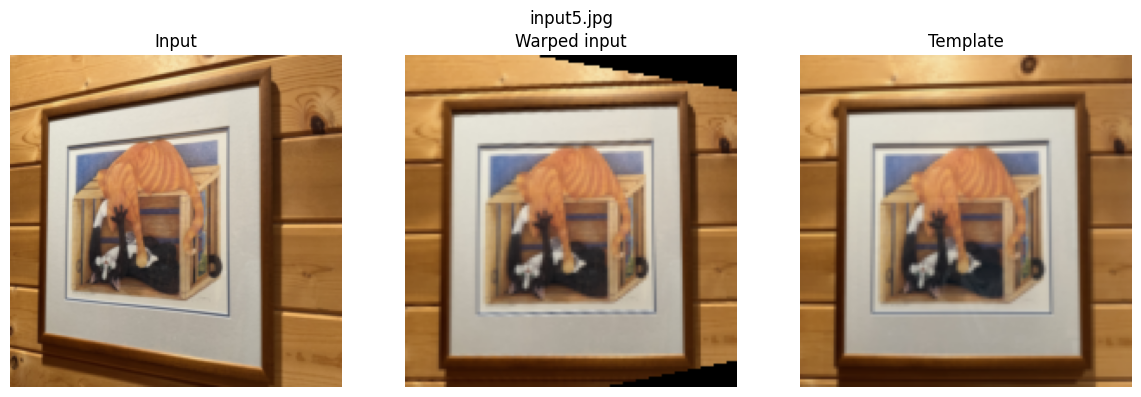


=== Pair 6 ===
Homography corner RMSE: 55.337 px


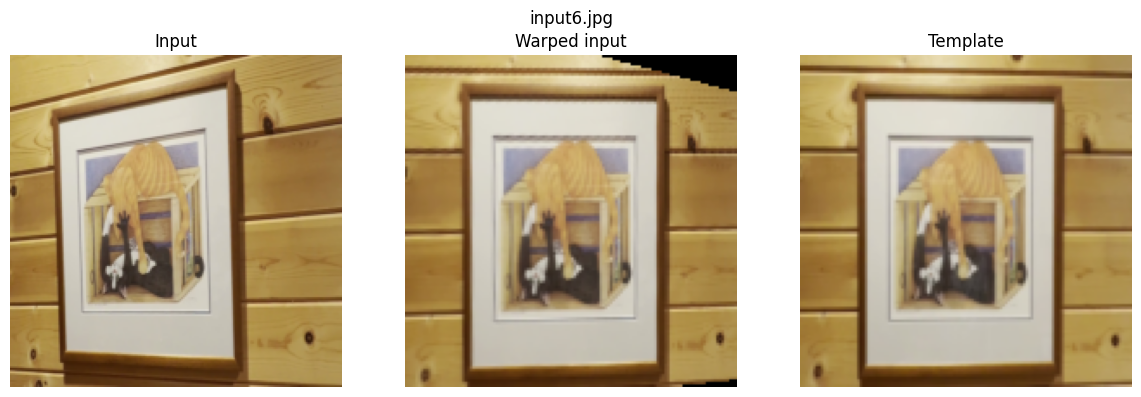


=== Pair 7 ===
Homography corner RMSE: 163.735 px


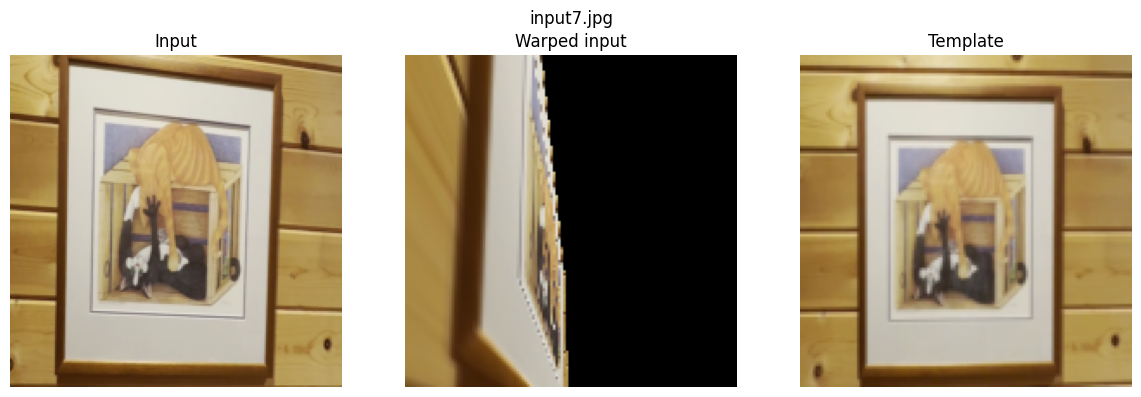


=== Pair 8 ===
Homography corner RMSE: 60.981 px


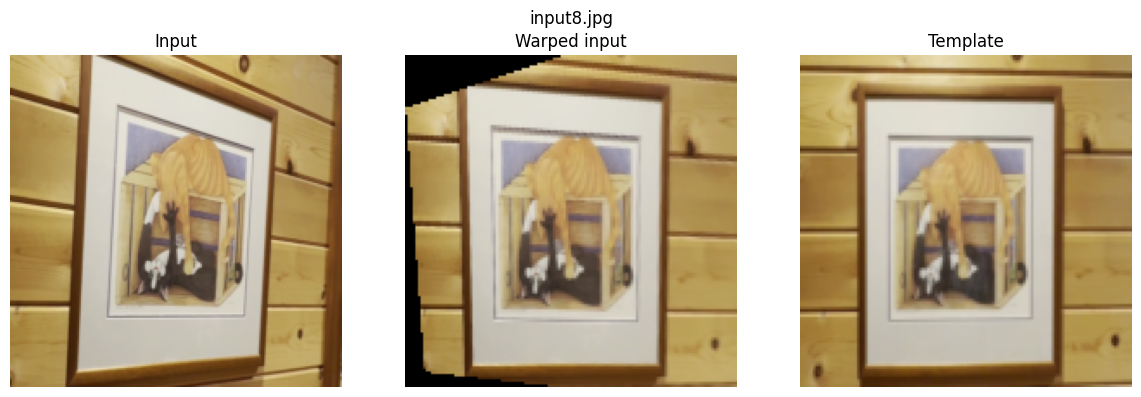


✅  Finished all available pairs.


In [ ]:
# ────────────────────────────────
# 0) Imports & one‑time setup
# ────────────────────────────────
import os, sys, cv2, numpy as np, matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def run_dlk_on_pair(inp_path:str, tpl_path:str, show:bool=True):
    """Runs your DLK pipeline on one input/template pair and returns the warped image."""
    # 1. Load & normalise originals ─────────────────────────────────────────────
    raw_input_img    = plt.imread(inp_path) / 255.0           # (H,W,3) float32 0‑1
    raw_template_img = plt.imread(tpl_path) / 255.0

    target_input_dim     = (192, 192)
    target_template_dim  = (128, 128)

    input_img_resized    = resize(raw_input_img,    target_input_dim,    anti_aliasing=True)
    template_img_resized = resize(raw_template_img, target_template_dim, anti_aliasing=True)

    # 2. Convert to TF tensors (+batch) ────────────────────────────────────────
    input_img_tf_batch    = tf.expand_dims(tf.convert_to_tensor(input_img_resized,    tf.float32), 0)
    template_img_tf_batch = tf.expand_dims(tf.convert_to_tensor(template_img_resized, tf.float32), 0)

    # 3. Prepare regression network input ─────────────────────────────────────
    template_img_padded   = tf.image.pad_to_bounding_box(template_img_tf_batch, 32, 32, 192, 192)
    network_input_for_reg = tf.concat(
        [
            tf.image.rgb_to_grayscale(template_img_padded),
            tf.image.rgb_to_grayscale(input_img_tf_batch)
        ],
        axis=-1
    )

    # 4. Compute initial homography (simple‑net / multi‑net) ──────────────────
    if input_parameters.initial_type == 'simple_net':
        homography_vector = regression_network(network_input_for_reg, training=False)
        H_init            = tf.concat([homography_vector, tf.ones((1,1))], axis=-1)
        H_init            = tf.reshape(H_init, [1,3,3])
        initial_matrix    = construct_matrix(H_init, scale_factor=0.25, batch_size=1)

    elif input_parameters.initial_type == 'multi_net':
        # --- first stage
        hv1         = regression_network_one (network_input_for_reg, training=False)
        M1          = construct_matrix_regression(1, hv1)
        tpl1        = LK_layer_regression.projective_inverse_warp(tf.cast(template_img_tf_batch, tf.float32), M1)
        # --- second stage
        net_in2     = tf.concat([tf.image.rgb_to_grayscale(tpl1),
                                 tf.image.rgb_to_grayscale(input_img_tf_batch)], axis=-1)
        hv2         = regression_network_two (net_in2, training=False)
        M2          = construct_matrix_regression(1, hv1, hv2)
        tpl2        = LK_layer_regression.projective_inverse_warp(tf.cast(template_img_tf_batch, tf.float32), M2)
        # --- third stage
        net_in3     = tf.concat([tf.image.rgb_to_grayscale(tpl2),
                                 tf.image.rgb_to_grayscale(input_img_tf_batch)], axis=-1)
        hv3         = regression_network_three(net_in3, training=False)

        H_init      = tf.concat([hv3, tf.ones((1,1))], axis=-1)
        H_init      = tf.reshape(H_init, [1,3,3])
        H_init      = tf.expand_dims(
                        np.dot(H_init[0,:,:], np.linalg.inv(M2[0,:,:])),
                        0
                      )
        initial_matrix = construct_matrix(H_init, scale_factor=0.25, batch_size=1)

    # 5. Build feature pyramids ───────────────────────────────────────────────
    inp_f1  = level_one_input  (input_img_tf_batch,    training=False)
    tpl_f1  = level_one_template(template_img_tf_batch, training=False)
    inp_f2  = level_two_input  (inp_f1, training=False)
    tpl_f2  = level_two_template(tpl_f1, training=False)
    inp_f3  = level_three_input(inp_f2, training=False)
    tpl_f3  = level_three_template(tpl_f2, training=False)

    if input_parameters.feature_map_type == 'special':
        inp_f1, tpl_f1 = calculate_feature_map(inp_f1), calculate_feature_map(tpl_f1)
        inp_f2, tpl_f2 = calculate_feature_map(inp_f2), calculate_feature_map(tpl_f2)
        inp_f3, tpl_f3 = calculate_feature_map(inp_f3), calculate_feature_map(tpl_f3)

    # 6. Coarse‑to‑fine LK optimisation ───────────────────────────────────────
    fk_loop       = input_parameters.num_iters
    updated_matrix = initial_matrix

    for _ in range(fk_loop):
        updated_matrix = LK_layer_three.update_matrix(tpl_f3, inp_f3, updated_matrix)
    updated_matrix = construct_matrix(updated_matrix, scale_factor=2.0, batch_size=1)

    for _ in range(fk_loop):
        updated_matrix = LK_layer_two .update_matrix(tpl_f2, inp_f2, updated_matrix)
    updated_matrix = construct_matrix(updated_matrix, scale_factor=2.0, batch_size=1)

    for _ in range(fk_loop):
        updated_matrix = LK_layer_one  .update_matrix(tpl_f1, inp_f1, updated_matrix)

    predicted_matrix = updated_matrix  # shape [1,3,3]

    # 7. Final warp at template resolution ────────────────────────────────────
    th, tw, _  = template_img_tf_batch[0].shape
    LK_final   = Lucas_Kanade_layer(batch_size=1,
                                    height_template=th,
                                    width_template=tw,
                                    num_channels=3)
    warped_inp = LK_final.projective_inverse_warp(
                    tf.cast(input_img_tf_batch, tf.float32),
                    predicted_matrix
                )                                             # [1,H,W,3]

    # 8. (optional)  corner error, prints, etc. ───────────────────────────────
    u = np.array([[0,127,127,0]]); v = np.array([[0,0,127,127]])
    err = average_cornner_error(1, predicted_matrix, u, v,
                                top_left_u=0, top_left_v=0,
                                bottom_right_u=127, bottom_right_v=127)
    print(f"Homography corner RMSE: {err:.3f} px")

    # 9. Visualisation ────────────────────────────────────────────────────────
    if show:
        fig, ax = plt.subplots(1,3, figsize=(12,4))
        ax[0].imshow((input_img_tf_batch[0] * 255).numpy().astype(np.uint8))
        ax[0].set_title("Input")
        ax[1].imshow((warped_inp[0].numpy() * 255).astype(np.uint8))
        ax[1].set_title("Warped input")
        ax[2].imshow((template_img_tf_batch[0] * 255).numpy().astype(np.uint8))
        ax[2].set_title("Template")
        for a in ax: a.axis('off')
        fig.suptitle(os.path.basename(inp_path))
        plt.tight_layout()
        plt.show()

    return warped_inp, predicted_matrix

# ────────────────────────────────
# 2) Loop over your 6 pairs
# ────────────────────────────────
for i in range(1, 9):                                    # 1 … 6
    inp_file = os.path.join('input',    f'input{i}.jpg')
    tpl_file = os.path.join('template', f'template{i}.jpg')

    if not (os.path.isfile(inp_file) and os.path.isfile(tpl_file)):
        print(f"[SKIP] Pair {i}: missing file(s).")
        continue

    print(f"\n=== Pair {i} ===")
    warped, H = run_dlk_on_pair(inp_file, tpl_file, show=True)

print("\n✅  Finished all available pairs.")
